In [ ]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

In [ ]:
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 50)

In [ ]:
salary_file = pd.ExcelFile('../contract_data/salaries_1985to2020_final.xlsx')
salaries = pd.read_excel(salary_file, 0)
players_info = pd.read_excel(salary_file, 1)

In [ ]:
### add years of the contract
years = list(salaries.groupby('player_id').apply(lambda x: [i for i in range(1, len(x)+1)]))
flatten = lambda l: [item for sublist in l for item in sublist]
salaries['years'] = flatten(years)

In [ ]:
salaries_98_20 = salaries.loc[salaries['season_end'] >= 1999]
unique_ids = list(pd.unique(salaries_98_20['player_id']))
filtered_players_info = players_info.loc[[True if pid in unique_ids else False for pid in players_info['_id']]]

In [ ]:
# Deal with rookie contracts of first round picks and second round picks
# separately. 
first_round_picks = filtered_players_info.loc[filtered_players_info['draft_round'] == '1st round']
second_round_picks = filtered_players_info.loc[filtered_players_info['draft_round'] == '2nd round']

In [ ]:
salaries_first_round = salaries_98_20.loc[[True if pid in list(first_round_picks['_id']) else False for pid in salaries_98_20['player_id']]].drop(columns=['team'])
# Drop entries with 'years' being 4 or less
# Prior to 2011 CBA, first round rookie contract is a 3+1 contract with the fourth year being team option
# After 2011 CBA, first round rookie contract is a 2+2 contract with both the 3rd and 4th year being team options
# Dropping values will potentially over-dropping some datapoints
salaries_first_round = salaries_first_round.loc[salaries_first_round['years'] > 4]

salaries_second_round = salaries_98_20.loc[[True if pid in list(second_round_picks['_id']) else False for pid in salaries_98_20['player_id']]].drop(columns=['team'])
# Drop entries with 'years' being 3 or less
salaries_second_round = salaries_second_round.loc[salaries_second_round['years'] > 3]

In [ ]:
# Following part is for fixing data in all stats

In [ ]:
stats = pd.read_excel('../season_data/advanced_stats/FINAL_ADVANCED_STATS/all_seasons_advanced_stats.xlsx')

In [ ]:
stats['error_in_name'] = stats['Year'].apply(lambda x: x is np.nan)
stats_need_fix = stats.loc[stats['error_in_name'] == True]

In [ ]:
stats_need_fix['Year'] = '2019-20'
name = stats_need_fix['name'].apply(lambda x: re.sub(r"\\.+", "", x))
slug = stats_need_fix['name'].apply(lambda x: re.sub(r".+\\", "", x))
stats_need_fix['name'], stats_need_fix['slug'] = name, slug

In [ ]:
stats = stats.loc[stats['error_in_name'] == False].append(stats_need_fix).drop(columns=['error_in_name'])

In [ ]:
# Create a primary key in two salaries table for joins
salaries_first_round['key'] = salaries_first_round['player_id'] + " " + salaries_first_round['season']
salaries_second_round['key'] = salaries_second_round['player_id'] + " " + salaries_second_round['season']
stats['key'] = stats['slug'] + " " + stats['Year']

In [ ]:
salaries_stats_first_round = salaries_first_round.join(stats.set_index('key'), on='key', how='left').dropna()
salaries_stats_second_round = salaries_second_round.join(stats.set_index('key'), on='key', how='left').dropna()

In [ ]:
first_round_counts = salaries_stats_first_round[['names', 'key']].groupby('key').count()
second_round_counts = salaries_stats_second_round[['names', 'key']].groupby('key').count()
not_traded_mid_season_first_round = list(first_round_counts.loc[first_round_counts['names'] == 1].index)
not_traded_mid_season_second_round = list(second_round_counts.loc[second_round_counts['names'] == 1].index)

In [ ]:
salary_caps_file = pd.ExcelFile('salary_caps.xlsx')
salary_caps = pd.read_excel(salary_caps_file, 0)
salary_caps = salary_caps.drop(columns=salary_caps.columns[0])
salary_caps_99_20 = salary_caps.set_index('season').loc[np.unique(salaries_stats_first_round['season'])]

In [ ]:
salaries_stats_first_round = salaries_stats_first_round.join(salary_caps_99_20, on='season', how='left')
salaries_stats_first_round = salaries_stats_first_round[salaries_stats_first_round['name'].notna()]
salaries_stats_second_round = salaries_stats_second_round.join(salary_caps_99_20, on='season', how='left')
salaries_stats_second_round = salaries_stats_second_round[salaries_stats_second_round['name'].notna()]

In [ ]:
salaries_stats_first_round['cap_space_usage'] = salaries_stats_first_round['salary'] / salaries_stats_first_round['salary_cap']
salaries_stats_second_round['cap_space_usage'] = salaries_stats_second_round['salary'] / salaries_stats_second_round['salary_cap']
salaries_stats_first_round['minutes_per_game'] = salaries_stats_first_round['minutes_played'] / salaries_stats_first_round['games_played']
salaries_stats_second_round['minutes_per_game'] = salaries_stats_second_round['minutes_played'] / salaries_stats_second_round['games_played']
salaries_stats_first_round['ast/tov_percentage'] = salaries_stats_first_round['assist_percentage'] / salaries_stats_first_round['turnover_percentage']
salaries_stats_second_round['ast/tov_percentage'] = salaries_stats_second_round['assist_percentage'] / salaries_stats_second_round['turnover_percentage']
salaries_stats_first_round['true_shooting*usage'] = salaries_stats_first_round['true_shooting_percentage'] * salaries_stats_first_round['usage_percentage']
salaries_stats_second_round['true_shooting*usage'] = salaries_stats_second_round['true_shooting_percentage'] * salaries_stats_second_round['usage_percentage']

In [ ]:
salaries_stats_first_round['ast/tov_percentage'] = salaries_stats_first_round['ast/tov_percentage'].replace([0, np.inf], np.nan)
salaries_stats_second_round['ast/tov_percentage'] = salaries_stats_second_round['ast/tov_percentage'].replace([0, np.inf], np.nan)
salaries_stats_first_round['true_shooting*usage'] = salaries_stats_first_round['true_shooting*usage'].replace([0], np.nan)
salaries_stats_second_round['true_shooting*usage'] = salaries_stats_second_round['true_shooting*usage'].replace([0], np.nan)

In [ ]:
salaries_stats_first_round

In [ ]:
def standardize(df, column):
    series = []
    for i in df[column]:
        series.append((i - df[column].mean())/df[column].std())
    return series

def correlation(df, column_1, column_2):
    return np.mean(df[column_1] * df[column_2])

def scatter_and_correlation(df, column_1, column_2, ax, order):
    copy = df.copy()
    copy[column_1 + "_standard"] = standardize(df, column_1)
    copy[column_2 + "_standard"] = standardize(df, column_2)
    copy.plot.scatter(x = column_1 + "_standard", y = column_2 + '_standard', ax=ax[order])
    return correlation(copy, column_1 + '_standard', column_2 + '_standard')

In [ ]:
def side_by_side_correlation(filtered_data, unfiltered_data, feature):
    fig, ax = plt.subplots(1,2,figsize=(10, 5))
    corr_filtered = scatter_and_correlation(filtered_data, feature, 'cap_space_usage', ax, 0)
    corr_unfiltered = scatter_and_correlation(unfiltered_data, feature, 'cap_space_usage', ax, 1)
    return (corr_filtered, corr_unfiltered, feature)

In [ ]:
salaries_stats_first_round.columns

In [ ]:
pg_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "POINT GUARD"].dropna()
sg_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "SHOOTING GUARD"].dropna()
sf_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "SMALL FORWARD"].dropna()
pf_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "POWER FORWARD"].dropna()
c_first_round = salaries_stats_first_round.loc[salaries_stats_first_round['positions'] == "CENTER"].dropna()

In [ ]:
pg_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "POINT GUARD"].dropna()
sg_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "SHOOTING GUARD"].dropna()
sf_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "SMALL FORWARD"].dropna()
pf_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "POWER FORWARD"].dropna()
c_second_round = salaries_stats_second_round.loc[salaries_stats_second_round['positions'] == "CENTER"].dropna()

In [ ]:
def find_percentile_for_feature(data, feature, percentile, position):
    return np.percentile(data.loc[(data['positions'] == position) & (data['minutes_played'] >= 700)][feature], percentile)

In [150]:
percentiles = np.arange(70, 95, 5)

for percentile in percentiles:
    print('The ' + str(percentile) + 'th percentile for assist_percentage among point guards is ' + 
         str(find_percentile_for_feature(salaries_stats_first_round, 
                                 'assist_percentage', percentile, 'POINT GUARD')))
    
    print('The ' + str(percentile) + 'th percentile for three_point_attempt_rate among shooting guards is ' + 
         str(find_percentile_for_feature(salaries_stats_first_round, 
                                 'three_point_attempt_rate', percentile, 'SHOOTING GUARD')))
    
    print('The ' + str(percentile) + 'th percentile for three_point_attempt_rate among small forwards is ' + 
         str(find_percentile_for_feature(salaries_stats_first_round, 
                                 'three_point_attempt_rate', percentile, 'SMALL FORWARD')))
    
    # add more similar statements to obtain values below
    
    print('\n')

The 70th percentile for assist_percentage among point guards is 35.04
The 70th percentile for three_point_attempt_rate among shooting guards is 0.4354
The 70th percentile for three_point_attempt_rate among small forwards is 0.406


The 75th percentile for assist_percentage among point guards is 36.4
The 75th percentile for three_point_attempt_rate among shooting guards is 0.461
The 75th percentile for three_point_attempt_rate among small forwards is 0.423


The 80th percentile for assist_percentage among point guards is 38.56
The 80th percentile for three_point_attempt_rate among shooting guards is 0.49
The 80th percentile for three_point_attempt_rate among small forwards is 0.4626


The 85th percentile for assist_percentage among point guards is 40.269999999999996
The 85th percentile for three_point_attempt_rate among shooting guards is 0.519
The 85th percentile for three_point_attempt_rate among small forwards is 0.5058499999999999


The 90th percentile for assist_percentage among po

5.1


,names,player_id,salary,season,season_end,season_start,key,years,name,positions,age,team,games_played,minutes_played,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player,is_combined_totals,Year,slug,salary_cap,cap_space_usage,minutes_per_game,ast/tov_percentage,true_shooting*usage
151,Cole Aldrich,aldrico01,1100600,2015-16,2016,2015,aldrico01 2015-16,5,Cole Aldrich,CENTER,27.0,LOS ANGELES CLIPPERS,60.0,800.0,21.3,0.626,0.000,0.373,11.9,27.1,19.6,10.0,2.9,6.7,19.6,18.4,1.4,2.0,3.5,0.209,-0.9,3.4,2.4,0.9,False,2015-16,aldrico01,70000000,0.015723,13.333333,0.510204,11.5184
1283,Bismack Biyombo,biyombi01,3000000,2015-16,2016,2015,biyombi01 2015-16,5,Bismack Biyombo,CENTER,23.0,TORONTO RAPTORS,82.0,1808.0,14.9,0.586,0.003,0.785,11.7,29.5,20.8,2.4,0.5,6.1,15.5,11.5,2.8,3.1,5.9,0.156,-1.3,1.1,-0.2,0.8,False,2015-16,biyombi01,70000000,0.042857,22.048780,0.154839,6.7390
1285,Bismack Biyombo,biyombi01,17000000,2017-18,2018,2017,biyombi01 2017-18,7,Bismack Biyombo,CENTER,25.0,ORLANDO MAGIC,82.0,1495.0,14.1,0.556,0.003,0.446,10.5,24.0,17.2,6.5,0.7,5.1,16.6,14.9,1.1,1.8,2.9,0.094,-2.6,0.2,-2.4,-0.2,False,2017-18,biyombi01,99093000,0.171556,18.231707,0.391566,8.2844
1433,Andrew Bogut,bogutan01,10000000,2009-10,2010,2009,bogutan01 2009-10,5,Andrew Bogut,CENTER,25.0,MILWAUKEE BUCKS,69.0,2229.0,20.7,0.540,0.002,0.260,10.1,26.4,17.9,10.3,0.9,6.2,11.4,23.3,2.6,4.8,7.5,0.161,0.8,2.2,3.1,2.8,False,2009-10,bogutan01,57700000,0.173310,32.304348,0.903509,12.5820
1434,Andrew Bogut,bogutan01,11000000,2010-11,2011,2010,bogutan01 2010-11,6,Andrew Bogut,CENTER,26.0,MILWAUKEE BUCKS,65.0,2297.0,16.7,0.496,0.005,0.292,9.8,27.1,18.3,10.4,1.1,5.8,13.0,19.6,0.3,5.1,5.4,0.112,-1.0,2.4,1.3,1.9,False,2010-11,bogutan01,58044000,0.189511,35.338462,0.800000,9.7216
1439,Andrew Bogut,bogutan01,12000000,2015-16,2016,2015,bogutan01 2015-16,11,Andrew Bogut,CENTER,31.0,GOLDEN STATE WARRIORS,70.0,1451.0,15.9,0.623,0.004,0.179,9.5,26.0,18.3,14.8,1.1,5.8,21.6,11.4,2.6,2.9,5.4,0.180,-0.9,3.2,2.4,1.6,False,2015-16,bogutan01,70000000,0.171429,20.728571,0.685185,7.1022
1640,Shawn Bradley,bradlsh01,4500000,2001-02,2002,2001,bradlsh01 2001-02,9,Shawn Bradley,CENTER,29.0,DALLAS MAVERICKS,53.0,757.0,14.6,0.562,0.006,0.393,7.9,17.8,12.9,3.8,1.9,6.0,11.6,12.9,1.3,1.0,2.3,0.144,-1.8,2.1,0.3,0.4,False,2001-02,bradlsh01,42500000,0.105882,14.283019,0.327586,7.2498
1641,Shawn Bradley,bradlsh01,4000000,2002-03,2003,2002,bradlsh01 2002-03,10,Shawn Bradley,CENTER,30.0,DALLAS MAVERICKS,81.0,1731.0,18.3,0.601,0.003,0.467,9.6,20.7,15.1,4.6,1.9,7.3,12.9,13.6,3.9,3.5,7.4,0.204,-0.4,3.0,2.6,2.0,False,2002-03,bradlsh01,40271000,0.099327,21.370370,0.356589,8.1736
1642,Shawn Bradley,bradlsh01,3500000,2003-04,2004,2003,bradlsh01 2003-04,11,Shawn Bradley,CENTER,31.0,DALLAS MAVERICKS,66.0,773.0,15.6,0.523,0.005,0.261,9.9,14.6,12.2,3.6,2.2,7.1,7.5,12.8,1.5,0.9,2.3,0.145,-1.5,1.6,0.1,0.4,False,2003-04,bradlsh01,43840000,0.079836,11.712121,0.480000,6.6944
1643,Shawn Bradley,bradlsh01,4000000,2004-05,2005,2004,bradlsh01 2004-05,12,Shawn Bradley,CENTER,32.0,DALLAS MAVERICKS,77.0,885.0,11.0,0.494,0.000,0.339,9.0,17.8,13.5,2.5,1.5,5.3,13.4,12.5,0.4,1.5,1.9,0.102,-3.6,1.6,-2.0,0.0,False,2004-05,bradlsh01,43870000,0.091178,11.493506,0.186567,6.1750


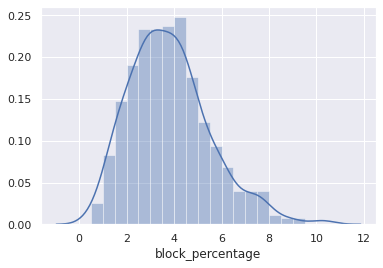

In [136]:
# Example 1
sns.distplot(salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "CENTER") & (salaries_stats_first_round['minutes_played'] >= 700)]['block_percentage'], bins=np.arange(0, 10, 0.5))
print(find_percentile_for_feature(salaries_stats_first_round, 
                                 'block_percentage', 80, 'CENTER'))
salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "CENTER") & 
                               (salaries_stats_first_round['minutes_played'] >= 700) & 
                               (salaries_stats_first_round['block_percentage'] >= 5.1) &
                               (salaries_stats_first_round['cap_space_usage'] <= 0.2)]

0.49


,names,player_id,salary,season,season_end,season_start,key,years,name,positions,age,team,games_played,minutes_played,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player,is_combined_totals,Year,slug,salary_cap,cap_space_usage,minutes_per_game,ast/tov_percentage,true_shooting*usage
240,Ray Allen,allenra02,3090000,2012-13,2013,2012,allenra02 2012-13,17,Ray Allen,SHOOTING GUARD,37.0,MIAMI HEAT,79.0,2035.0,14.7,0.599,0.510,0.243,2.6,10.1,6.6,10.2,1.7,0.6,12.5,19.3,3.4,1.9,5.4,0.126,1.1,-0.8,0.3,1.2,False,2012-13,allenra02,58044000,0.053235,25.759494,0.816000,11.5607
241,Ray Allen,allenra02,3229050,2013-14,2014,2013,allenra02 2013-14,18,Ray Allen,SHOOTING GUARD,38.0,MIAMI HEAT,73.0,1936.0,12.8,0.590,0.569,0.214,1.6,11.4,6.7,11.1,1.5,0.4,12.4,16.8,2.5,1.5,4.1,0.101,0.5,-0.9,-0.4,0.8,False,2013-14,allenra02,58679000,0.055029,26.520548,0.895161,9.9120
357,James Anderson,anderja01,916099,2013-14,2014,2013,anderja01 2013-14,5,James Anderson,SHOOTING GUARD,24.0,PHILADELPHIA 76ERS,80.0,2309.0,10.9,0.530,0.490,0.148,2.7,11.7,7.0,9.9,1.6,1.0,12.2,15.9,0.9,0.9,1.9,0.039,-1.5,-1.0,-2.6,-0.3,False,2013-14,anderja01,58679000,0.015612,28.862500,0.811475,8.4270
394,Nick Anderson,anderni01,5051906,1999-00,2000,1999,anderni01 1999-00,10,Nick Anderson,SHOOTING GUARD,32.0,SACRAMENTO KINGS,72.0,2094.0,11.8,0.479,0.508,0.097,4.1,12.8,8.4,8.6,2.2,0.5,10.4,18.1,0.3,2.5,2.8,0.064,-0.6,0.3,-0.3,0.9,False,1999-00,anderni01,34000000,0.148585,29.083333,0.826923,8.6699
907,Brent Barry,barrybr01,3960000,1999-00,2000,1999,barrybr01 1999-00,5,Brent Barry,SHOOTING GUARD,28.0,SEATTLE SUPERSONICS,80.0,2726.0,14.6,0.609,0.564,0.222,2.0,13.1,7.5,16.0,1.9,0.8,15.5,14.9,4.9,2.5,7.5,0.131,1.0,0.9,1.8,2.6,False,1999-00,barrybr01,34000000,0.116471,34.075000,1.032258,9.0741
908,Brent Barry,barrybr01,4320000,2000-01,2001,2000,barrybr01 2000-01,6,Brent Barry,SHOOTING GUARD,29.0,SEATTLE SUPERSONICS,67.0,1778.0,16.6,0.660,0.571,0.257,2.1,11.4,6.8,19.4,2.4,0.6,16.2,13.5,4.6,1.2,5.8,0.157,2.3,0.9,3.3,2.4,False,2000-01,barrybr01,35500000,0.121690,26.537313,1.197531,8.9100
909,Brent Barry,barrybr01,4680000,2001-02,2002,2001,barrybr01 2001-02,7,Brent Barry,SHOOTING GUARD,30.0,SEATTLE SUPERSONICS,81.0,3040.0,19.3,0.652,0.490,0.296,2.3,14.6,8.6,21.3,2.6,0.9,15.6,16.2,8.8,3.3,12.1,0.191,3.8,1.6,5.5,5.8,False,2001-02,barrybr01,42500000,0.110118,37.530864,1.365385,10.5624
910,Brent Barry,barrybr01,5040000,2002-03,2003,2002,barrybr01 2002-03,8,Brent Barry,SHOOTING GUARD,31.0,SEATTLE SUPERSONICS,75.0,2480.0,15.8,0.597,0.508,0.279,2.2,12.2,7.1,25.0,2.5,0.5,18.0,14.9,4.8,2.5,7.3,0.141,1.1,1.5,2.6,2.9,False,2002-03,barrybr01,40271000,0.125152,33.066667,1.388889,8.8953
911,Brent Barry,barrybr01,5400000,2003-04,2004,2003,barrybr01 2003-04,9,Brent Barry,SHOOTING GUARD,32.0,SEATTLE SUPERSONICS,59.0,1803.0,18.3,0.668,0.590,0.258,1.4,11.9,6.7,30.5,2.5,0.7,22.6,15.8,4.9,0.7,5.7,0.151,3.2,0.1,3.2,2.4,False,2003-04,barrybr01,43840000,0.123175,30.559322,1.349558,10.5544
912,Brent Barry,barrybr01,4264900,2004-05,2005,2004,barrybr01 2004-05,10,Brent Barry,SHOOTING GUARD,33.0,SAN ANTONIO SPURS,81.0,1742.0,14.0,0.580,0.610,0.294,1.9,10.8,6.4,16.3,1.2,0.8,11.0,15.6,3.5,2.7,6.1,0.168,1.1,1.3,2.4,1.9,False,2004-05,barrybr01,43870000,0.097217,21.506173,1.481818,9.0480


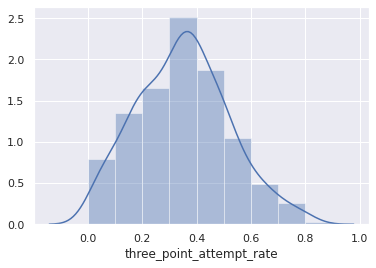

In [138]:
# Example 2
sns.distplot(salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "SHOOTING GUARD") &
                                                (salaries_stats_first_round['minutes_played'] >= 700)]['three_point_attempt_rate'],
                                                 bins=np.arange(0, 1, 0.1))
print(find_percentile_for_feature(salaries_stats_first_round, 
                                 'three_point_attempt_rate', 80, 'SHOOTING GUARD'))
salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == "SHOOTING GUARD") & 
                               (salaries_stats_first_round['minutes_played'] >= 700) & 
                               (salaries_stats_first_round['three_point_attempt_rate'] >= 0.49) &
                               (salaries_stats_first_round['cap_space_usage'] <= 0.2)]

0.4626


,names,player_id,salary,season,season_end,season_start,key,years,name,positions,age,team,games_played,minutes_played,player_efficiency_rating,true_shooting_percentage,three_point_attempt_rate,free_throw_attempt_rate,offensive_rebound_percentage,defensive_rebound_percentage,total_rebound_percentage,assist_percentage,steal_percentage,block_percentage,turnover_percentage,usage_percentage,offensive_win_shares,defensive_win_shares,win_shares,win_shares_per_48_minutes,offensive_box_plus_minus,defensive_box_plus_minus,box_plus_minus,value_over_replacement_player,is_combined_totals,Year,slug,salary_cap,cap_space_usage,minutes_per_game,ast/tov_percentage,true_shooting*usage
286,Al-Farouq Aminu,aminual01,7500000,2015-16,2016,2015,aminual01 2015-16,6,Al-Farouq Aminu,SMALL FORWARD,25.0,PORTLAND TRAIL BLAZERS,82.0,2341.0,12.7,0.533,0.485,0.217,4.5,18.6,11.5,8.8,1.5,1.8,13.2,16.9,1.7,2.3,4.0,0.082,-0.2,0.2,0.1,1.2,False,2015-16,aminual01,70000000,0.107143,28.548780,0.666667,9.0077
337,Derek Anderson,anderde01,9742500,2006-07,2007,2006,anderde01 2006-07,11,Derek Anderson,SMALL FORWARD,32.0,CHARLOTTE BOBCATS,50.0,1190.0,13.7,0.586,0.517,0.361,2.8,8.6,5.6,17.6,2.3,0.5,14.1,15.1,2.0,0.9,2.9,0.117,-0.3,0.6,0.4,0.7,False,2006-07,anderde01,53135000,0.183354,23.800000,1.248227,8.8486
338,Derek Anderson,anderde01,901397,2006-07,2007,2006,anderde01 2006-07,12,Derek Anderson,SMALL FORWARD,32.0,CHARLOTTE BOBCATS,50.0,1190.0,13.7,0.586,0.517,0.361,2.8,8.6,5.6,17.6,2.3,0.5,14.1,15.1,2.0,0.9,2.9,0.117,-0.3,0.6,0.4,0.7,False,2006-07,anderde01,53135000,0.016964,23.800000,1.248227,8.8486
339,Derek Anderson,anderde01,400000,2006-07,2007,2006,anderde01 2006-07,13,Derek Anderson,SMALL FORWARD,32.0,CHARLOTTE BOBCATS,50.0,1190.0,13.7,0.586,0.517,0.361,2.8,8.6,5.6,17.6,2.3,0.5,14.1,15.1,2.0,0.9,2.9,0.117,-0.3,0.6,0.4,0.7,False,2006-07,anderde01,53135000,0.007528,23.800000,1.248227,8.8486
590,Metta World Peace,artesro01,7258960,2012-13,2013,2012,artesro01 2012-13,14,Metta World Peace,SMALL FORWARD,33.0,LOS ANGELES LAKERS,75.0,2530.0,12.5,0.517,0.500,0.205,4.5,11.5,8.1,6.9,2.5,1.2,9.8,17.5,1.9,2.6,4.6,0.086,-0.5,0.9,0.4,1.5,False,2012-13,artesro01,58044000,0.125060,33.733333,0.704082,9.0475
708,Luke Babbitt,babbilu01,1227000,2016-17,2017,2016,babbilu01 2016-17,6,Luke Babbitt,SMALL FORWARD,27.0,MIAMI HEAT,68.0,1065.0,8.3,0.563,0.747,0.053,1.2,13.5,7.3,4.8,0.9,0.8,8.0,13.0,0.8,1.0,1.8,0.081,-2.0,-0.1,-2.0,0.0,False,2016-17,babbilu01,94143000,0.013033,15.661765,0.600000,7.3190
972,Shane Battier,battish01,5393300,2006-07,2007,2006,battish01 2006-07,6,Shane Battier,SMALL FORWARD,28.0,HOUSTON ROCKETS,82.0,2988.0,12.0,0.589,0.570,0.173,2.6,10.4,6.5,9.2,1.4,1.5,9.3,12.1,4.4,4.6,9.0,0.144,0.3,2.0,2.3,3.2,False,2006-07,battish01,53135000,0.101502,36.439024,0.989247,7.1269
973,Shane Battier,battish01,5883600,2007-08,2008,2007,battish01 2007-08,7,Shane Battier,SMALL FORWARD,29.0,HOUSTON ROCKETS,80.0,2907.0,11.7,0.561,0.596,0.163,5.2,10.5,7.9,8.0,1.4,2.3,10.5,11.7,3.6,4.6,8.2,0.135,0.0,1.9,2.0,2.9,False,2007-08,battish01,55630000,0.105763,36.337500,0.761905,6.5637
976,Shane Battier,battish01,7354500,2010-11,2011,2010,battish01 2010-11,10,Shane Battier,SMALL FORWARD,32.0,HOUSTON ROCKETS,59.0,1818.0,12.9,0.577,0.551,0.186,3.6,13.9,8.8,12.1,1.5,2.7,12.5,12.3,2.3,1.7,4.0,0.105,0.8,1.1,1.9,1.8,False,2010-11,battish01,58044000,0.126706,30.813559,0.968000,7.0971
977,Shane Battier,battish01,3000000,2011-12,2012,2011,battish01 2011-12,11,Shane Battier,SMALL FORWARD,33.0,MIAMI HEAT,65.0,1499.0,9.7,0.504,0.627,0.127,4.6,7.7,6.2,8.0,2.2,1.8,10.7,10.7,1.2,2.1,3.3,0.104,-0.7,1.6,0.9,1.1,False,2011-12,battish01,58044000,0.051685,23.061538,0.747664,5.3928


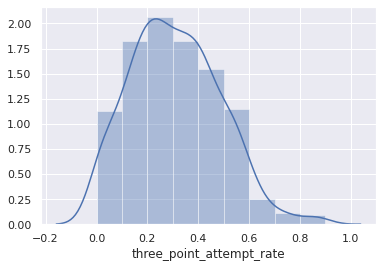

In [140]:
# Example 3
pos = 'SMALL FORWARD'

sns.distplot(salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == pos) &
                                                (salaries_stats_first_round['minutes_played'] >= 700)]['three_point_attempt_rate'],
                                                 bins=np.arange(0, 1, 0.1))
print(find_percentile_for_feature(salaries_stats_first_round, 
                                 'three_point_attempt_rate', 80, pos))
salaries_stats_first_round.loc[(salaries_stats_first_round['positions'] == pos) & 
                               (salaries_stats_first_round['minutes_played'] >= 700) & 
                               (salaries_stats_first_round['three_point_attempt_rate'] >= 0.4626) &
                               (salaries_stats_first_round['cap_space_usage'] <= 0.2)]

In [ ]:
# Blocks below are for visualizations of unified 6 features

# No need to run them

In [ ]:
features = ['player_efficiency_rating',
              'ast/tov_percentage', 'true_shooting*usage', 'offensive_box_plus_minus', 'value_over_replacement_player', 'win_shares']

In [ ]:
correlations = {"C":{}, "PF":{}, "SF":{}, "SG":{}, "PG":{}}

In [ ]:
for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(c_first_round.loc[c_first_round["minutes_played"] >= 700], c_first_round, feature)
    print(filtered, unfiltered, feature)
    correlations["C"][feature] = filtered
    
for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(pf_first_round.loc[pf_first_round["minutes_played"] >= 700], pf_first_round, feature)
    correlations["PF"][feature] = filtered
    
for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(sf_first_round.loc[sf_first_round["minutes_played"] >= 700], sf_first_round, feature)
    correlations["SF"][feature] = filtered
    
for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(sg_first_round.loc[sg_first_round["minutes_played"] >= 700], sg_first_round, feature)
    print(filtered, unfiltered, feature)
    correlations["SG"][feature] = filtered

for feature in features:
    filtered, unfiltered, feature = side_by_side_correlation(pg_first_round.loc[pg_first_round["minutes_played"] >= 700], pg_first_round, feature)
    correlations["PG"][feature] = filtered

In [ ]:
df = pd.DataFrame.from_dict({(i,j): correlations[i][j] 
                            for i in correlations.keys() 
                            for j in correlations[i].keys()},
                            orient='index')
df.index = pd.MultiIndex.from_tuples(df.index)
df = df.reset_index()
df = df.rename(columns={'level_0': "Position", "level_1": "Feature", 0: "Correlation with cap space usage"})

In [ ]:
for feature in features:
    print(side_by_side_correlation(c_second_round.loc[c_second_round["minutes_played"] >= 350], c_second_round, feature))

for feature in features:
    print(side_by_side_correlation(pf_second_round.loc[pf_second_round["minutes_played"] >= 350], pf_second_round, feature))

for feature in features:
    print(side_by_side_correlation(sf_second_round.loc[sf_second_round["minutes_played"] >= 350], sf_second_round, feature))

for feature in features:
    print(side_by_side_correlation(sg_second_round.loc[sg_second_round["minutes_played"] >= 350], sg_second_round, feature))

for feature in features:
    print(side_by_side_correlation(pg_second_round.loc[pg_second_round["minutes_played"] >= 350], pg_second_round, feature))